In [1]:
import meds
import numpy as np
import galsim
import fitsio

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
import os

band = 'i'
tilename = 'DES2122+0001'
MEDS_DIR = 'outputs-%s' % tilename
MEDSCONF = 'y3v02'

meds_path = os.path.join(
    MEDS_DIR,
    'meds',
    MEDSCONF,
    tilename,
    "{tilename}_{band}_meds-{medsconf}.fits.fz".format(
        tilename=tilename,
        band=band,
        medsconf=MEDSCONF))

yaml_path = os.path.join(
    MEDS_DIR,
    "simple_des_y3_sims",
    MEDSCONF,
    "band_info_files",
    "{tilename}_{band}_info.yaml".format(
        tilename=tilename, band=band))

In [3]:
m = meds.MEDS(meds_path)
ii = m.get_image_info()
cat = m.get_cat()

In [4]:
import yaml

with open(yaml_path, "r") as fp:
    info = yaml.load(fp, Loader=yaml.Loader)

In [5]:
np.where(cat['file_id'][:, 1] > 0)

(array([3, 4]),)

In [6]:
iobj = 3
iind = 1

In [7]:
# check the image info struct
file_id = cat['file_id'][iobj, iind]
assert file_id > 0
print('file_id:', file_id)
print('image:', os.path.basename(ii['image_path'][file_id]))

for key in ['image_path', 'weight_path', 'bmask_path', 'bkg_path']:
    assert ii[key][file_id] == info['src_info'][file_id-1][key].replace('$MEDS_DIR', MEDS_DIR)
    
assert np.allclose(ii['scale'][file_id], info['src_info'][file_id-1]['scale'])

# check the WCS
hd = fitsio.read_header(
    ii['image_path'][file_id], ext=ii['image_ext'][file_id])
hd = {k.upper(): hd[k] for k in hd if k is not None}
gs_wcs = galsim.FitsWCS(header=hd)

import json

hs = json.loads(ii['wcs'][file_id])
hd = {k.upper(): hd[k] for k in hd if k is not None}
json_wcs = galsim.FitsWCS(header=hd)

for x in range(10, 100, 10):
    for y in range(11, 101, 10):
        pos = galsim.PositionD(x=x, y=y)
        gs_sky_pos = gs_wcs.toWorld(pos)
        json_sky_pos = json_wcs.toWorld(pos)
        
        assert gs_sky_pos.ra/galsim.degrees == json_sky_pos.ra/galsim.degrees
        assert gs_sky_pos.dec/galsim.degrees == json_sky_pos.dec/galsim.degrees

file_id: 2
image: D00232321_i_c54_r2357p01_immasked.fits.fz


In [8]:
pos = galsim.PositionD(x=cat['orig_col'][iobj, iind]+1, y=cat['orig_row'][iobj, iind]+1)
wcs = gs_wcs.local(pos)

print(wcs.dudx, wcs.dudy, wcs.dvdx, wcs.dvdy)
print(
    cat['dudcol'][iobj, iind],
    cat['dudrow'][iobj, iind],
    cat['dvdcol'][iobj, iind],
    cat['dvdrow'][iobj, iind])

assert np.allclose(cat['dudrow'][iobj, iind], wcs.dudy)
assert np.allclose(cat['dudcol'][iobj, iind], wcs.dudx)
assert np.allclose(cat['dvdrow'][iobj, iind], wcs.dvdy)
assert np.allclose(cat['dvdcol'][iobj, iind], wcs.dvdx)

0.0010333293505799675 -0.2628992355930364 -0.26266045338610666 -0.00020182834834476865
0.001033329410201277 -0.26289923557392697 -0.26266045335227584 -0.00020182834202034372


In [9]:
# check x, y
sky_pos = galsim.CelestialCoord(
    ra=cat['ra'][iobj] * galsim.degrees,
    dec=cat['dec'][iobj] * galsim.degrees)
print(cat['ra'][iobj], cat['dec'][iobj])
pos = gs_wcs.toImage(sky_pos)
print(pos, cat['orig_col'][iobj, iind]+1, cat['orig_row'][iobj, iind]+1)
assert np.allclose(pos.x-1, cat['orig_col'][iobj, iind])
assert np.allclose(pos.y-1, cat['orig_row'][iobj, iind])

pos = json_wcs.toImage(sky_pos)
print(pos, cat['orig_col'][iobj, iind]+1, cat['orig_row'][iobj, iind]+1)
assert np.allclose(pos.x-1, cat['orig_col'][iobj, iind])
assert np.allclose(pos.y-1, cat['orig_row'][iobj, iind])

320.93236855515204 0.016682651217869913
galsim.PositionD(1347.7562990439637,3848.0358280483156) 1347.7562990440701 3848.0358280486575
galsim.PositionD(1347.7562990439637,3848.0358280483156) 1347.7562990440701 3848.0358280486575


In [10]:
from matts_misc.simple_des_y3_sims.des_piff import DES_Piff
psf_model = DES_Piff(os.path.expandvars(info['src_info'][file_id-1]['piff_path']))
from matts_misc.simple_des_y3_sims.psf_wrapper import PSFWrapper

psf_model = PSFWrapper(psf_model, gs_wcs)

AssertionError: 

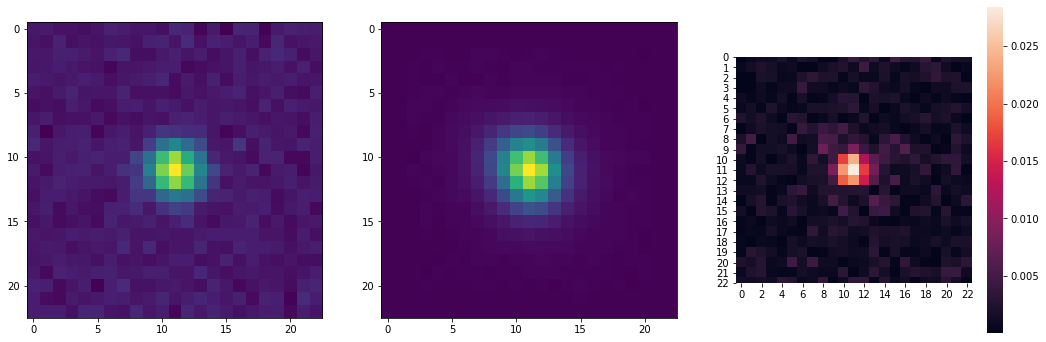

In [11]:
# check the psf
pos = galsim.PositionD(x=cat['orig_col'][iobj, iind]+1, y=cat['orig_row'][iobj, iind]+1)
wcs = gs_wcs.local(pos)

im = psf_model.get_rec(row=pos.y-1, col=pos.x-1)[15:38, 15:38]

m_im = m.get_cutout(iobj, iind, type='psf')[15:38, 15:38]

sc = np.std(m_im[:, 0])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
axs[0].imshow(m_im/sc)
axs[1].imshow(im/sc)
sns.heatmap(np.abs(m_im - im), ax=axs[2], square=True)

assert np.allclose(m_im, im)

AssertionError: 

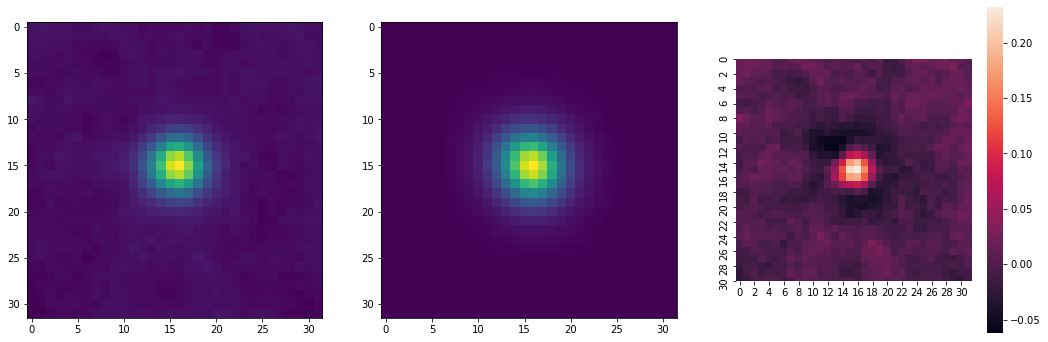

In [12]:
# check the images
pos = galsim.PositionD(x=cat['orig_col'][iobj, iind]+1, y=cat['orig_row'][iobj, iind]+1)
wcs = gs_wcs.local(pos)

gal = galsim.Exponential(half_light_radius=0.5).withFlux(
    64000
).shear(
    g1=0.02, g2=0.0)
obj = gal
psf = psf_model.getPSF(pos)
obj = galsim.Convolve([gal, psf])

dx = pos.x - int(pos.x + 0.5)
dy = pos.y - int(pos.y + 0.5)

if cat['box_size'][iobj] % 2 == 0:
    if pos.x > int(pos.x + 0.5):
        dx -= 0.5
    else:
        dx += 0.5
    if pos.y > int(pos.y + 0.5):
        dy -= 0.5
    else:
        dy += 0.5

im = obj.drawImage(
    method='no_pixel', wcs=wcs, offset=(dx, dy), setup_only=True)
dshape = im.array.shape[0]

if (cat['box_size'][iobj] % 2) != (im.array.shape[0] % 2 != 0):
    dshape += 1

if dshape < cat['box_size'][iobj]:
    dshape = cat['box_size'][iobj]
    
im = obj.drawImage(
    nx=dshape, ny=dshape, 
    method='no_pixel', wcs=wcs, offset=(dx, dy))
im = im.array

if dshape != cat['box_size'][iobj]:
    diff = (dshape - cat['box_size'][iobj]) // 2
    im = im[diff:-diff, diff:-diff]

im /= im.sum()

m_im = m.get_cutout(iobj, iind, type='image')
m_im /= m_im.sum()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
axs[0].imshow(m_im)
axs[1].imshow(im)
sns.heatmap((m_im - im)/np.max(np.abs(m_im)), ax=axs[2], square=True)

assert np.allclose(m_im, im, rtol=1e-6, atol=1e-5)

In [ ]:
# m.close()